In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
%matplotlib inline  

/Users/yunqiguo/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Generate the real_X and real_Y dataset

In [2]:
data_type = tf.float32

def sample_batch(sample_size):
    real_X = tf.distributions.Bernoulli(probs = 0.3, dtype = data_type).sample([sample_size,1])
    real_Y = prob(real_X)
    return real_X, real_Y

def prob(X):
    return X +  tf.distributions.Bernoulli(probs = 0.5, dtype = data_type).sample(tf.shape(X))

def counts(real_Y):
    unique, counts = np.unique(real_Y, return_counts=True)
    return np.asarray((unique, counts/float(real_Y.size))).T

with tf.Session() as sess:
    sample_size = 50000.
    real_X, real_Y = sess.run(sample_batch(50000))
    print counts(real_X)
    print counts(real_Y)

[[0.      0.70176]
 [1.      0.29824]]
[[0.      0.34956]
 [1.      0.5013 ]
 [2.      0.14914]]


### 2. Build the adversarial nets

In [3]:
nn_type = tf.float32

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.0)
    return tf.random_normal(shape = size, stddev = xavier_stddev)

X = tf.placeholder(nn_type, shape = [None, 1])
Y = tf.placeholder(nn_type, shape = [None, 1])

D_W1 = tf.Variable(xavier_init([1,100]))
D_b1 = tf.Variable(tf.zeros(shape = [100]))

D_W2 = tf.Variable(xavier_init([100,1]))
D_b2 = tf.Variable(tf.zeros(shape = [1]))

theta_D = [D_W1, D_b1, D_W2, D_b2]

Z = tf. placeholder(nn_type, shape = [None, 100])

G_W1 = tf.Variable(xavier_init([100, 10]))
G_b1 = tf.Variable(tf.zeros(shape = [10]))

G_W2 = tf.Variable(xavier_init([10, 1]))
G_b2 = tf.Variable(tf.zeros(shape = [1]))

theta_G = [G_W1, G_b1, G_W2, G_b2]

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size = [m, n])

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_x = G_log_prob
    
    return G_x

def discriminator(y):
    D_h1 = tf.nn.relu(tf.matmul(y, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

def plot(real_X, real_Y, G_X, G_Y ):
    df = pd.DataFrame({"real_X": real_X.flatten(), "real_Y": real_Y.flatten(), "fake_X": G_X.flatten(), "fake_Y": G_Y.flatten()})
    plot = df.plot(kind='density')
    fig = plot.get_figure()
    return fig

G_sample_X = generator(Z)
G_sample_Y = prob(G_sample_X)

D_real, D_logit_real = discriminator(Y)
D_fake, D_logit_fake = discriminator(G_sample_Y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size = 128
Z_dim = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('result_dis_1/'):
    os.makedirs('result_dis_1/')

i = 0
    
for it in range(100):
    if it % 50 == 0:
        real_X, real_Y = sess.run(sample_batch(mb_size * 10))
        samples_X = sess.run(G_sample_X, feed_dict={Z: sample_Z(mb_size * 10, Z_dim)})
        samples_Y = sess.run(G_sample_Y, feed_dict={G_sample_X: samples_X})
        fig = plot(real_X, real_Y, samples_X, samples_Y)
        plt.savefig('result_dis_1/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    real_X, real_Y = sess.run(sample_batch(mb_size))

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: real_X, Y:real_Y, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D_loss: 1.45
G_loss: 0.5535
()
Iter: 10
D_loss: 1.285
G_loss: 0.6896
()
Iter: 20
D_loss: 1.254
G_loss: 0.9184
()
Iter: 30
D_loss: 1.2
G_loss: 0.8969
()
Iter: 40
D_loss: 1.208
G_loss: 0.9176
()
Iter: 50
D_loss: 1.249
G_loss: 0.8797
()
Iter: 60
D_loss: 1.248
G_loss: 0.7712
()
Iter: 70
D_loss: 1.274
G_loss: 0.8647
()
Iter: 80
D_loss: 1.317
G_loss: 0.8205
()
Iter: 90
D_loss: 1.3
G_loss: 0.7978
()


### 3. Print

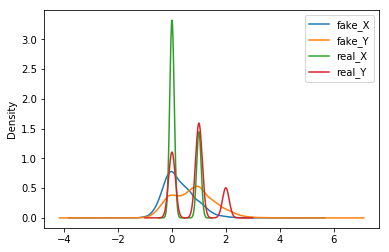

In [4]:
samples_X = sess.run(G_sample_X, feed_dict={Z: sample_Z(5000, Z_dim)})
samples_Y = sess.run(G_sample_Y, feed_dict={G_sample_X: samples_X})
real_X, real_Y = sess.run(sample_batch(5000))
_ = plot(real_X, real_Y, samples_X, samples_Y)